In [1]:
# import math
import pandas as pd
import numpy as np
import requests
from io import StringIO
import arcticdb as adb
from arcticdb import LibraryOptions

import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt

1. Liquidity: currency of the bear market
    1. market impact: stay mid-large caps on the short side
    2. Market Cap: function and fields
2. Exchange: OTC
4. Crowded shorts: 
    1. Percentage of the free float
    2. ratios and prudence

4. Valuations
    1. P/E : poor predictor of imminent shorts. Value traps are often cheap
    2. High PBR indicate highly leveraged balance sheet. Everything is about timing
    3. Dividend yield:
        1. avg 5 year and underperformance
        2. navigate ex-date


### Downloading information for all S&P 500 companies

How it works:
1. Fetch data: Request Wikipedia page with browser headers to avoid blocking
2. Extract table: Parse HTML and select the second table [1] containing company data
3. Clean up: Rename 'GICS Sector' → 'sector' and set ticker symbols as index
4. Verify: Display first 5 rows
5. Result: DataFrame indexed by ticker (e.g., AAPL, MSFT) with columns for company name, sector, date added, etc.

In [2]:

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}  # (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
response= requests.get(url, headers=headers)
df_SP500 = pd.read_html(StringIO(response.text))[0]
df_SP500 = df_SP500.rename(columns={'GICS Sector':'sector'})
df_SP500.set_index('Symbol', inplace=True)

bm_ticker = '^GSPC'
tickers = [bm_ticker] + df_SP500.index.tolist() 
df_SP500.head()

,Security,sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Symbol,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


### Fetch company fundamentals from YFinance

**Objective:** Pull detailed fundamentals and metadata for all S&P 500 tickers (plus benchmark) into a single DataFrame.

**Steps:**
- Initialize storage: Create empty dictionary to hold per-ticker info
- Loop tickers: For each symbol, call `yf.Ticker(symbol).info` to retrieve fundamentals and metadata
- Handle errors: On fetch failure, log the exception and store `None` for that ticker
- Build DataFrame: Convert the dictionary to a DataFrame indexed by ticker
- (Optional) Persist: CSV export commented out for later use

**Result:** DataFrame with one row per ticker containing YFinance fundamentals (market cap, valuations, dividends, short interest, etc.) ready for cleaning and screening.

In [4]:
sp500_info_dict = {}

for symbol in tickers:
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        sp500_info_dict[symbol] = info
    except Exception as e:
        print(f"Error fetching info for {symbol}: {e}")
        sp500_info_dict[symbol] = None
        
sp500_info_df= pd.DataFrame.from_dict(sp500_info_dict, orient='index')
# sp500_info_df.to_csv('sp500_info.csv')

### Liquidity is the currency of bear markets

Clean and engineer key screening metrics for short selling: liquidity, market cap, and short interest indicators.

How it works:
1. Date formatting: Convert dividend dates from Unix timestamps to YYYY-MM-DD format
2. Market cap fix: Calculate market cap from shares × price when API value is zero; convert to millions
3. Liquidity metric: Compute daily dollar volume traded (prefer 10-day average over standard average)
4. Short interest: Calculate short % of float from raw shares data; fill missing values from API field
5. Display subset: Show key columns for liquidity, shorts, valuations, and dividends

Result: Cleaned DataFrame with standardized metrics ready for screening high-liquidity, heavily-shorted, or dividend-paying stocks.

In [5]:
sp500_info_df[['exDividendDate', 'dividendDate']] = sp500_info_df[['exDividendDate', 'dividendDate']].apply(lambda x: pd.to_datetime(x).dt.strftime('%Y-%m-%d'))

# Market Cap correction
sp500_info_df['marketCap_calculated'] = sp500_info_df['sharesOutstanding'].mul(sp500_info_df['currentPrice'])
sp500_info_df['market_Cap']  = np.where(sp500_info_df['marketCap'] == 0, sp500_info_df['marketCap_calculated'], sp500_info_df['marketCap'])
sp500_info_df['market_Cap']  = round(sp500_info_df['market_Cap'] *1e-6)

# Average Liquidity calculation
value_traded  = round(sp500_info_df['averageVolume'].mul(sp500_info_df['currentPrice']) *1e-6)
value_traded_avg10  = round(sp500_info_df['averageDailyVolume10Day'].mul(sp500_info_df['currentPrice']) *1e-6)
sp500_info_df['value_traded'] = np.where(~pd.isna(value_traded_avg10), value_traded_avg10, value_traded)

# Crowded shorts
sp500_info_df['shortfloat'] = round(sp500_info_df['sharesShort'].div(sp500_info_df['floatShares']),3)
sp500_info_df['shortPctFloat'] = np.where(~pd.isna(sp500_info_df['shortfloat']), 
                                          sp500_info_df['shortfloat'], sp500_info_df['shortPercentOfFloat'])

sp500_info_df[['shortName','sector','exchange','market_Cap', 'value_traded', 'currentPrice',#'sharesOutstanding', 'averageDailyVolume10Day', 'averageVolume',
 'shortPctFloat', 'shortRatio', #'sharesShort', 'floatShares', 'shortPercentOfFloat',
'exDividendDate', 'dividendDate','dividendYield', 'fiveYearAvgDividendYield', 'payoutRatio',
'trailingPE', 'forwardPE', 'priceToBook', ]].head(10)

,shortName,sector,exchange,market_Cap,value_traded,currentPrice,shortPctFloat,shortRatio,exDividendDate,dividendDate,dividendYield,fiveYearAvgDividendYield,payoutRatio,trailingPE,forwardPE,priceToBook
^GSPC,S&P 500,NaN,SNP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MMM,3M Company,Industrials,NYQ,86137.0,368.0,161.72,0.013,2.50,1970-01-01,1970-01-01,1.81,4.00,0.4609,25.792664,18.708391,18.562902
AOS,A.O. Smith Corporation,Industrials,NYQ,9540.0,72.0,68.08,0.044,3.45,1970-01-01,1970-01-01,2.03,1.72,0.3666,18.350405,16.501482,5.139277
ABT,Abbott Laboratories,Healthcare,NYQ,216809.0,785.0,124.57,0.009,2.33,1970-01-01,1970-01-01,2.02,1.72,0.2915,15.649497,21.948380,4.251100
ABBV,AbbVie Inc.,Healthcare,NYQ,407983.0,1314.0,230.84,0.010,3.21,1970-01-01,1970-01-01,3.00,3.75,4.9015,174.878780,16.196299,-154.408020
ACN,Accenture plc,Technology,NYQ,168268.0,1127.0,271.34,0.019,3.02,1970-01-01,1970-01-01,2.40,1.47,0.5017,22.424793,18.232912,5.409274
ADBE,Adobe Inc.,Technology,NMS,149810.0,1323.0,353.16,0.028,2.54,1970-01-01,NaN,NaN,0.12,0.0000,21.147305,13.413526,12.670326
AMD,"Advanced Micro Devices, Inc.",Technology,NMS,351022.0,5600.0,215.61,0.022,0.92,1970-01-01,NaN,NaN,NaN,0.0000,112.296875,33.382570,5.774237
AES,The AES Corporation,Utilities,NYQ,10062.0,86.0,14.13,0.031,3.04,1970-01-01,1970-01-01,4.98,3.58,0.4608,9.296053,6.107471,2.603648
AFL,AFLAC Incorporated,Financial Services,NYQ,58810.0,319.0,109.96,0.012,2.60,1970-01-01,1970-01-01,2.22,2.19,0.2943,14.449409,14.914948,2.015027


### Identify the most heavily shorted stocks by short ratio

Screen for stocks with the highest short ratio (days to cover) to find crowded short positions that may face squeeze risk.

How it works:
1. Rank stocks: Calculate percentile rank of shortRatio across all S&P 500 stocks
2. Sort and select: Sort descending and take top 10 tickers with highest ratios
3. Display metrics: Show shortPctFloat and shortRatio for these heavily-shorted names
4. Interpretation: High short ratio means many days of average volume needed to cover all short positions

Result: Top 10 stocks where shorts may face difficulty exiting positions quickly, indicating potential squeeze candidates or genuine distress.

In [6]:
short_ratio = sp500_info_df['shortRatio'].rank(pct=True).sort_values(ascending=False).index[:10].tolist()
sp500_info_df.loc[short_ratio, ['shortName','sector','shortPctFloat', 'shortRatio']].round(3).head(10)

,shortName,sector,shortPctFloat,shortRatio
ERIE,Erie Indemnity Company,Financial Services,0.087,14.57
TPL,Texas Pacific Land Corporation,Energy,0.086,12.18
TROW,"T. Rowe Price Group, Inc.",Financial Services,0.104,12.03
RMD,ResMed Inc.,Healthcare,0.073,11.59
FOX,Fox Corporation,Communication Services,0.045,11.18
IP,International Paper Company,Consumer Cyclical,0.099,10.48
LNT,Alliant Energy Corporation,Utilities,0.077,10.31
APO,"Apollo Global Management, Inc.",Financial Services,0.070,9.84
CHTR,"Charter Communications, Inc.",Communication Services,0.196,9.66
NWS,News Corporation,Communication Services,0.015,9.49


In [7]:
sp500_info_df.groupby('sector')[['shortPctFloat','shortRatio']].mean().sort_values(by='shortPctFloat', ascending=False).round(3)

,shortPctFloat,shortRatio
sector,,
Communication Services,0.053,4.324
Consumer Defensive,0.045,3.459
Consumer Cyclical,0.041,3.224
Technology,0.039,3.075
Basic Materials,0.035,2.937
Energy,0.034,4.029
Healthcare,0.034,3.208
Utilities,0.034,4.416
Real Estate,0.030,3.918


### Identify the most heavily shorted stocks by short as a percentage of free float

Screen for stocks with the highest short as a percentage of free float to find crowded short positions that may face squeeze risk.

How it works:
1. Rank stocks: Calculate percentile rank of shortRatio across all S&P 500 stocks
2. Sort and select: Sort descending and take top 10 tickers with highest ratios
3. Display metrics: Show shortPctFloat and shortRatio for these heavily-shorted names
4. Interpretation: High short as a percentage of free float means demand for short (shares borrowed) has increased as a percentage of the supply (free float)

In [8]:
high_short_float = sp500_info_df['shortPercentOfFloat'].rank(pct=True).sort_values(ascending=False).index[:10].tolist()
sp500_info_df.loc[high_short_float, ['shortName','sector','shortPercentOfFloat', 'shortRatio']].round(3).head(10)

,shortName,sector,shortPercentOfFloat,shortRatio
CHTR,"Charter Communications, Inc.",Communication Services,0.248,9.66
MRNA,"Moderna, Inc.",Healthcare,0.217,7.02
DVA,DaVita Inc.,Healthcare,0.211,7.29
SMCI,"Super Micro Computer, Inc.",Technology,0.197,3.95
CPB,The Campbell's Company,Consumer Defensive,0.188,3.94
ON,ON Semiconductor Corporation,Technology,0.168,4.55
MGM,MGM Resorts International,Consumer Cyclical,0.132,4.94
IP,International Paper Company,Consumer Cyclical,0.129,10.48
FOXA,Fox Corporation,Communication Services,0.128,6.61
DAY,"Dayforce, Inc.",Technology,0.126,2.81


### Analyze dividend metrics by sector

Compare dividend characteristics across sectors to identify high-yield sectors and assess dividend sustainability.

How it works:
1. Group by sector: Aggregate all S&P 500 stocks by GICS sector
2. Calculate means: Compute average dividendYield, fiveYearAvgDividendYield, and payoutRatio per sector
3. Sort by 5-year average: Rank sectors from highest to lowest historical dividend yield

Interpretation: In chapter 3 we calculated returns by group. We identified defensives and cyclical sectors. Defensive sectors generally underperform the benchmark. They therefore have to compensate their shareholders with generous dividend yields. 

In [9]:
sp500_info_df.groupby('sector')[['dividendYield', 'fiveYearAvgDividendYield', 'payoutRatio']].mean().sort_values(by='fiveYearAvgDividendYield', ascending=False).round(2)

,dividendYield,fiveYearAvgDividendYield,payoutRatio
sector,,,
Real Estate,4.35,3.66,8.11
Utilities,3.10,3.34,0.58
Energy,3.05,3.17,0.58
Consumer Defensive,3.69,2.76,0.79
Communication Services,1.89,2.47,0.45
Consumer Cyclical,2.07,2.33,0.39
Financial Services,2.05,2.26,0.37
Basic Materials,2.52,2.18,1.33
Healthcare,1.75,1.60,0.61


In [10]:
sp500_info_df[['exDividendDate', 'dividendDate']].tail()

,exDividendDate,dividendDate
YUM,1970-01-01,1970-01-01
ZBRA,NaN,NaN
ZBH,1970-01-01,1970-01-01
ZTS,1970-01-01,1970-01-01
BF.B,NaN,NaN


### Compare valuation multiples across sectors

Examine price-to-earnings and price-to-book ratios by sector to identify relatively expensive or cheap sectors.

How it works:
1. Group by sector: Aggregate stocks by GICS sector classification
2. Calculate medians: Use median (not mean) for trailingPE, forwardPE, and priceToBook to avoid outlier distortion
3. Sort by trailing PE: Rank sectors from most to least expensive based on historical earnings

Interpretation: Technology have sported gravity defying P/E and still lead the charge in the current bull market. Forward looking P/E look reasonable while trailing P/E are rich. This means earnings momentum and growth prospects are strong. The moment earnings momentum slows down, valuations will compress and those stocks will have a rude encounter with Newtonian physics.
High PBR indicates high leveraged balance sheets compared to valuations. As soon as the rent of money goes up, fragile sheets crumble.

In [11]:
sp500_info_df.groupby('sector')[['trailingPE', 'forwardPE', 'priceToBook']].median().sort_values(by='trailingPE', ascending=False).round(1)

,trailingPE,forwardPE,priceToBook
sector,,,
Technology,32.0,21.8,6.0
Communication Services,31.0,17.5,3.0
Real Estate,29.5,35.5,2.2
Industrials,27.8,21.5,5.3
Basic Materials,27.4,17.5,2.7
Healthcare,26.1,17.2,3.0
Consumer Cyclical,25.5,19.1,5.0
Consumer Defensive,23.2,14.7,3.2
Utilities,20.0,18.1,2.1


In [ ]:
batch_size = 25 ; start= '2015-01-01' ; end = None

px_df = batch_px_df(tickers,batch_size, start, end,show_batch = False)
px_df.columns.names = ['ticker']
px_df = px_df.round(2) 
px_df_rel = round(px_df.divide(px_df[bm_ticker], axis=0).mul(px_df.iloc[0,list(px_df.columns).index(bm_ticker)]),1)

px_df_rel = px_df_rel.round(2) 

In [12]:
def initialise_adb_library_local(uri_path, library_name):
    uri = f"lmdb://{uri_path}" # this will set up the storage using the local file system
    ac = adb.Arctic(uri)
    library = ac.get_library(library_name, create_if_missing=True,)# library_options=LibraryOptions(dynamic_schema=True))
    return library

def adb_concat_single_column(library, symbols, column_name):
    symbols_list = [symbol for symbol in symbols if symbol in library.list_symbols()]
    comp_list_from_adb = [library.read(symbol, columns=[column_name]).data.rename(columns={column_name: symbol}) for symbol in symbols_list]
    return pd.concat(comp_list_from_adb, axis=1)

### Initialize Arctic database and retrieve S&P 500 price data

**Objective:** Access local Arctic database (LMDB backend) to retrieve closing prices for all S&P 500 stocks and compute relative performance versus benchmark.

**Steps:**
- Initialize library: Create or connect to 'SP500' library in local LMDB database at 'data' folder
- Retrieve Close prices: Use adb_concat_single_column() to extract 'Close' column for all symbols, concatenate into wide-format DataFrame
- Round and normalize: Convert absolute prices to 2 decimals (px_df)
- Calculate relative prices: Divide each stock by benchmark (^GSPC) and normalize to benchmark's opening value; round to 1 decimal (px_df_rel)
- Clean data: Remove any timezone information and standardize format

**Result:** Two DataFrames ready for analysis—px_df contains absolute closing prices while px_df_rel shows each stock's relative performance indexed to benchmark (100 = benchmark starting value).

In [13]:
library_SP500 = initialise_adb_library_local('data', 'SP500')

px_df = adb_concat_single_column(library_SP500, library_SP500.list_symbols(), 'Close').round(2)
px_df_rel = round(px_df.divide(px_df[bm_ticker], axis=0).mul(px_df.iloc[0,list(px_df.columns).index(bm_ticker)]),1)
px_df_rel = px_df_rel.round(2) 

In [14]:
def beta(df,bm_col):
    log_returns = np.log(df/df.shift(1))
    var = log_returns[bm_col].var()
    cov = log_returns.cov()
    beta = round(cov.loc[:,bm_col] / var,2)
    return beta

### Define beta calculation function

Calculate stock beta (systematic risk) relative to benchmark using log returns covariance method.

How it works:
1. Compute log returns: Calculate log(price_t / price_t-1) for all stocks and benchmark
2. Calculate variance: Compute variance of benchmark returns
3. Compute covariance: Build covariance matrix between all stocks and benchmark
4. Calculate beta: Divide each stock's covariance with benchmark by benchmark variance
5. Round results: Return betas rounded to 2 decimals

Result: Beta values where β>1 indicates higher volatility than market, β<1 means lower volatility, and β≈1 moves with market.

In [15]:
month_end_list = px_df.resample('ME', closed='left', label='right').last().index.to_list()

window = 12 * 3
beta_df = pd.DataFrame( )
bm_col = '^GSPC'
for t,dt in enumerate(month_end_list):
    beta_monthly_df =  beta(px_df[dt:month_end_list[t + window]],bm_col)
    beta_df = pd.concat([beta_df,beta_monthly_df],axis =1)
    beta_df = beta_df.rename(columns={bm_col: month_end_list[t + window]})
    if month_end_list[t + window] == month_end_list[-1]:
        print(t,dt,month_end_list[t+window])
        break

beta_df.tail()

95 2022-12-31 00:00:00 2025-12-31 00:00:00


,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,...,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31,2025-11-30,2025-12-31
ANET,1.24,1.24,1.29,1.29,1.26,1.29,1.32,1.37,1.45,1.51,...,1.59,1.55,1.55,1.60,1.59,1.62,1.66,1.69,1.76,1.79
NVR,0.67,0.75,0.73,0.71,0.70,0.72,0.73,0.75,0.77,0.77,...,0.95,0.86,0.84,0.81,0.82,0.80,0.78,0.75,0.67,0.69
HOLX,0.97,0.95,0.94,0.95,0.96,0.96,0.97,0.97,0.95,0.96,...,0.56,0.51,0.53,0.51,0.49,0.47,0.46,0.42,0.39,0.38
VMC,1.19,1.18,1.15,1.17,1.14,1.14,1.11,1.14,1.11,1.12,...,1.01,0.93,0.90,0.90,0.91,0.90,0.91,0.88,0.87,0.87
EQR,0.71,0.71,0.66,0.65,0.64,0.64,0.65,0.62,0.60,0.54,...,0.72,0.75,0.76,0.77,0.77,0.77,0.78,0.74,0.71,0.70


### Calculate rolling 36-month beta for all stocks

Compute monthly updated betas using a 3-year rolling window to track how systematic risk evolves over time.

How it works:
1. Create month-end list: Resample price data to month-end dates for period boundaries
2. Set rolling window: Use 36 months (12 × 3) for beta stability while capturing regime changes
3. Loop through months: For each month, calculate beta using data from that month through +36 months ahead
4. Build beta DataFrame: Each column represents betas as of a specific month-end date
5. Stop at data end: Break loop when reaching the last available month

Result: DataFrame with betas for each stock (rows) calculated at each month-end (columns), showing how risk profiles change across market cycles.

In [ ]:
monthly_beta_df = beta_df.T

for ticker in library_SP500.list_symbols():
    df =  library_SP500.read(ticker).data
    df = df.dropna(subset =['Close','High','Low','Open' ])
    df = pd.concat([df,monthly_beta_df[ticker]],axis =1)
    df = df.rename(columns={ticker:'beta'})
    df['beta'] = df['beta'].ffill()
    df = df.loc[:, ~df.columns.duplicated(keep='last')]
    library_SP500.write(ticker, df)
df.iloc[-5:,-5:]

#### Append Rolling Beta to Arctic Database

**Objective:** Write rolling 36-month beta values to Arctic database for all S&P 500 tickers, ensuring each stock record includes monthly-updated systematic risk metric.

**Steps:**
- Transpose beta_df: Convert from ticker-indexed to date-indexed format with tickers as columns (monthly_beta_df)
- Loop through all tickers: For each symbol in library_SP500.list_symbols(), read complete ticker data from database
- Drop missing OHLC data: Remove rows with NaN in price fields to ensure clean data before beta merge
- Concatenate beta: Merge monthly_beta_df[ticker] column to ticker DataFrame on matching dates (axis=1)
- Rename and forward-fill: Rename concatenated column to 'beta'; apply forward-fill to propagate values through data gaps
- Clean and write: remove duplicate columns; write updated DataFrame back to library

**Result:** All S&P 500 stock records in Arctic database now contain monthly-rolling beta values; forward-filled values ensure continuous coverage from first available beta date forward.

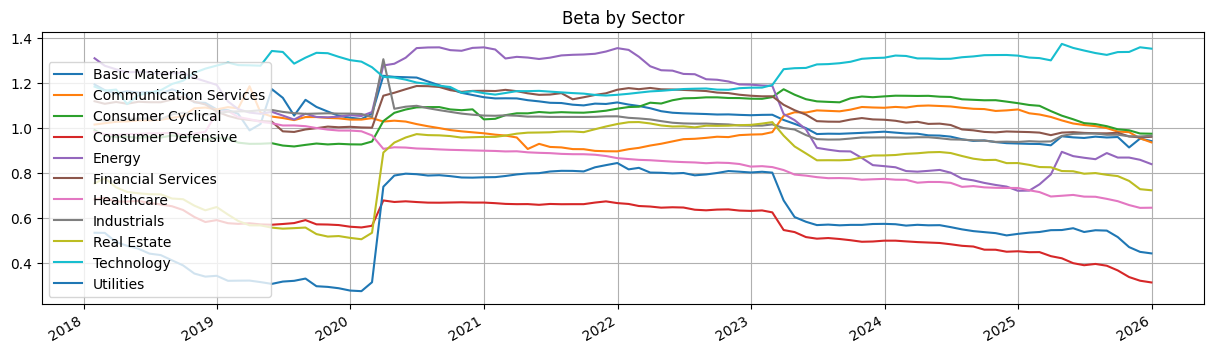

In [16]:
df_SP500_beta = pd.DataFrame()
df_SP500_beta = pd.concat([sp500_info_df['sector'], beta_df], axis=1)

sector_beta_pivot = pd.pivot_table(df_SP500_beta, values=list(beta_df.columns), 
                                   index= ['sector'], aggfunc="mean").T
sector_beta_pivot.plot(figsize=(15,4),title = 'Beta by Sector', grid=True)
plt.legend(loc='lower left')

### Visualize beta trends by sector over time

Aggregate individual stock betas to sector level and plot time series to identify which sectors become more/less risky.

How it works:
1. Merge data: Combine sector labels from sp500_info_df with beta time series
2. Pivot table: Calculate mean beta per sector for each month using pd.pivot_table()
3. Transpose: Flip table so months are rows (x-axis) and sectors are columns (series)
4. Plot: Generate time series chart showing beta evolution by sector

Result: Line chart revealing which sectors (e.g., Technology, Energy) exhibit higher systematic risk and how sector betas shift during bull/bear markets.

In [17]:
daily_log_returns = np.log(px_df/px_df.shift(1))
daily_rel_log_returns = daily_log_returns.sub(daily_log_returns[bm_col],axis=0)
cum_returns_abs = daily_log_returns.cumsum().apply(np.exp)-1
cum_returns_rel = daily_rel_log_returns.cumsum().apply(np.exp)-1

### Calculate absolute and relative returns for strategy analysis

Compute daily log returns in both absolute and benchmark-relative terms for performance attribution.

How it works:
1. Daily log returns: Calculate log(price_t / price_t-1) for all stocks
2. Relative log returns: Subtract benchmark returns from each stock's returns (excess returns)
3. Cumulative absolute: Apply exp(cumsum(log_returns)) - 1 to get total returns
4. Cumulative relative: Apply exp(cumsum(relative_log_returns)) - 1 to get benchmark-adjusted returns

Result: Four DataFrames enabling analysis of both absolute performance and alpha generation (outperformance vs. S&P 500).

### Calculate and visualize sector performance metrics

**Objective:** Compare sector-level absolute and relative returns to identify which sectors outperform or underperform the S&P 500 benchmark.

**Steps:**
1. Merge sector labels with cumulative return time series to organize returns by sector classification
2. Group returns by sector and calculate mean performance across all constituent stocks within each sector
3. Plot both absolute returns (total gains) and relative returns (excess over benchmark) for sector comparison

**Result:** Two visualizations showing sector performance trends—absolute chart reveals total returns while relative chart highlights which sectors generated alpha (outperformance) versus the benchmark.

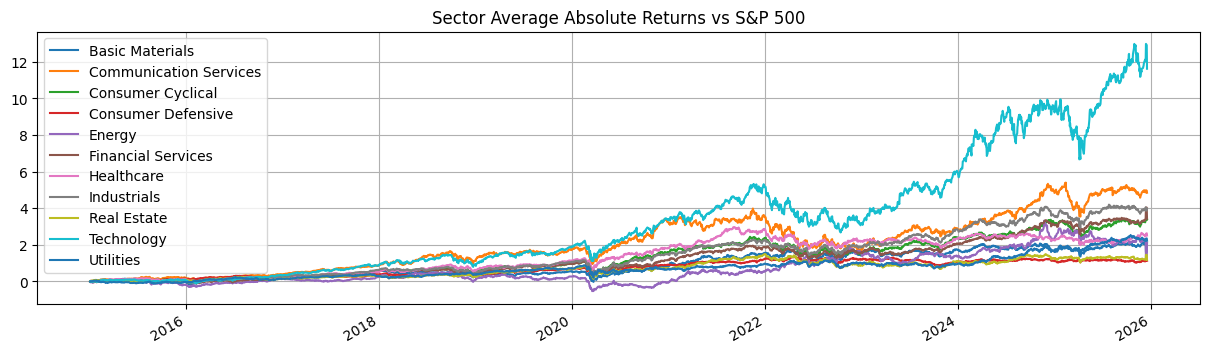

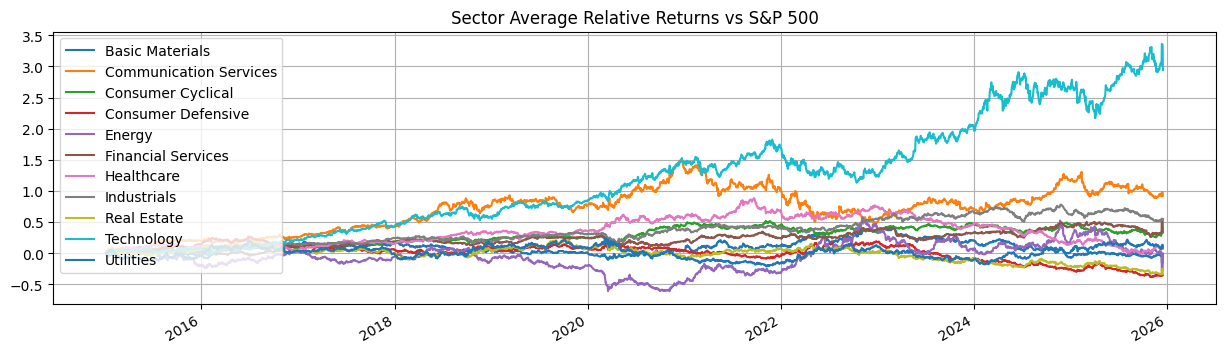

In [18]:
sector_abs_returns = pd.concat([sp500_info_df['sector'],cum_returns_abs.T],axis=1)
sector_avg_abs_returns = sector_abs_returns.groupby('sector').mean().T
sector_avg_abs_returns.plot(figsize=(15,4), title='Sector Average Absolute Returns vs S&P 500', grid=True)
plt.legend(loc='upper left')
plt.show()

sector_rel_returns = pd.concat([sp500_info_df['sector'],cum_returns_rel.T],axis=1)
sector_avg_rel_returns = sector_rel_returns.groupby('sector').mean().T
sector_avg_rel_returns.plot(figsize=(15,4), title='Sector Average Relative Returns vs S&P 500', grid=True)
plt.legend(loc='upper left')
plt.show()


### Compare high-beta vs. low-beta sector performance

Analyze performance difference between cyclical high-beta sectors (Technology, Consumer Cyclical) and defensive low-beta sectors (Utilities, Consumer Defensive).

How it works:
1. Define sector groups: Select high-beta sectors (Technology, Consumer Cyclical) and low-beta sectors (Utilities, Consumer Defensive)
2. Filter returns: Extract returns for stocks in each sector group from sector_rel_returns and sector_abs_returns
3. Calculate averages: Compute mean returns across all stocks in high-beta and low-beta groups
4. Build comparison DataFrame: Combine benchmark, high/low beta averages, and their spread (high minus low)
5. Plot relative returns: Chart showing relative performance vs. S&P 500 for both groups and their difference
6. Plot absolute returns: Chart showing total returns including benchmark for comparison

Result: Two charts demonstrating beta factor premium—high-beta sectors outperform in bull markets but underperform in bear markets, while low-beta sectors provide defensive characteristics. The spread line shows the cyclical nature of the beta factor.

Note: The absolute chart shows the returns without adjustment for the benchmark returns. This is why it looks so much better. The relative chart shows the excess returns over the benchmark.

<Axes: title={'center': 'High Low Beta Sectors Absolute Returns'}>

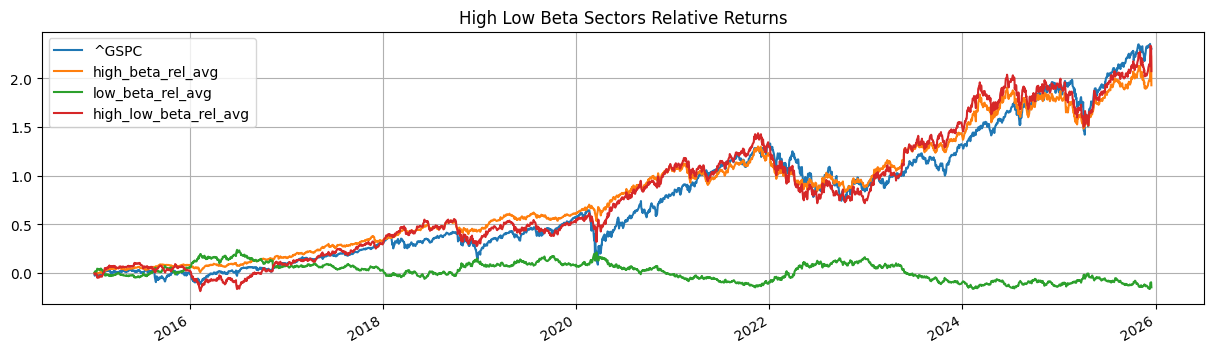

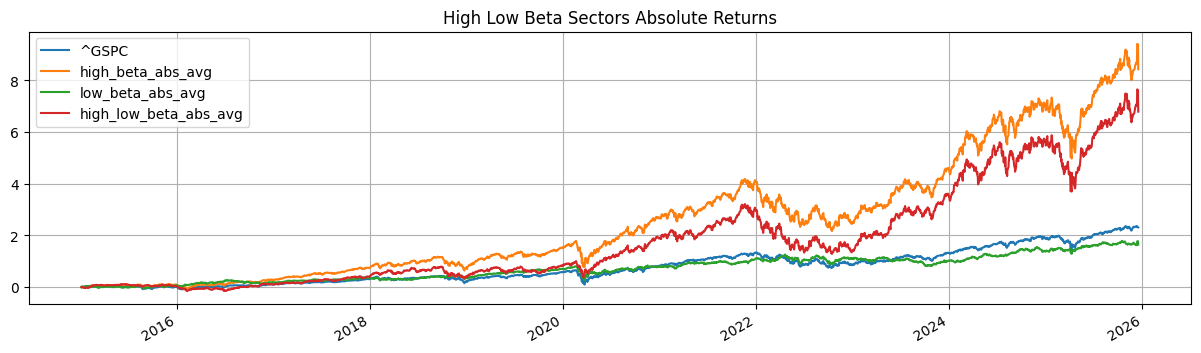

In [19]:
high_beta_sectors = ['Consumer Cyclical', 'Technology']
low_beta_sectors = ['Consumer Defensive', 'Utilities']

high_beta_rel_returns = sector_rel_returns.loc[sector_rel_returns['sector'].isin(high_beta_sectors)].drop(columns=['sector'])
low_beta_rel_returns = sector_rel_returns.loc[sector_rel_returns['sector'].isin(low_beta_sectors)].drop(columns=['sector'])

high_beta_abs_returns = sector_abs_returns.loc[sector_abs_returns['sector'].isin(high_beta_sectors)].drop(columns=['sector'])
low_beta_abs_returns = sector_abs_returns.loc[sector_abs_returns['sector'].isin(low_beta_sectors)].drop(columns=['sector'])

beta_cum_returns = pd.DataFrame()
beta_cum_returns[bm_col]= cum_returns_abs[bm_col].copy()
beta_cum_returns['high_beta_rel_avg'] = high_beta_rel_returns.mean(axis=0)
beta_cum_returns['low_beta_rel_avg'] = low_beta_rel_returns.mean(axis=0)
beta_cum_returns['high_low_beta_rel_avg'] = beta_cum_returns['high_beta_rel_avg'].sub(
    beta_cum_returns['low_beta_rel_avg'] )

beta_cum_returns['high_beta_abs_avg'] = high_beta_abs_returns.mean(axis=0)
beta_cum_returns['low_beta_abs_avg'] = low_beta_abs_returns.mean(axis=0)
beta_cum_returns['high_low_beta_abs_avg'] = beta_cum_returns['high_beta_abs_avg'].sub(
    beta_cum_returns['low_beta_abs_avg'] )

beta_cum_returns[[bm_col,'high_beta_rel_avg','low_beta_rel_avg', 'high_low_beta_rel_avg']].plot(
    grid = True, figsize= (15,4), title = 'High Low Beta Sectors Relative Returns')

beta_cum_returns[[bm_col,'high_beta_abs_avg','low_beta_abs_avg', 'high_low_beta_abs_avg']].plot(
    grid = True, figsize= (15,4), title = 'High Low Beta Sectors Absolute Returns')

### Combine sector information with cumulative returns

Merge sector labels with cumulative return matrices to enable sector-level performance analysis.

How it works:
1. Transpose returns: Flip cum_returns DataFrames so tickers are rows (matching sp500_info_df index)
2. Concatenate sector: Add 'sector' column from sp500_info_df to returns data
3. Create both versions: Build sector_rel_returns (benchmark-adjusted) and sector_abs_returns (total returns)

Result: DataFrames indexed by ticker with sector label + all daily cumulative returns, ready for groupby operations to analyze sector performance.

### Backtest high-beta vs. low-beta stock strategy

This code backtests a daily-rebalanced beta factor strategy tracking high-beta vs. low-beta stock portfolios.

Steps:
1. Each month, select the 5 highest-beta and 5 lowest-beta stocks based on previous month's rankings
2. Calculate mean daily relative log returns across the 5 stocks in each portfolio during the holding period
3. Concatenate all daily returns across holding periods into continuous time series
4. Compute the long-short spread (top minus bottom), add benchmark returns, and apply cumulative sum
5. Plot cumulative performance showing how each strategy performs over time vs. the benchmark

<Axes: title={'center': 'Top vs Bottom Beta 5 Stocks Cumulative Returns'}>

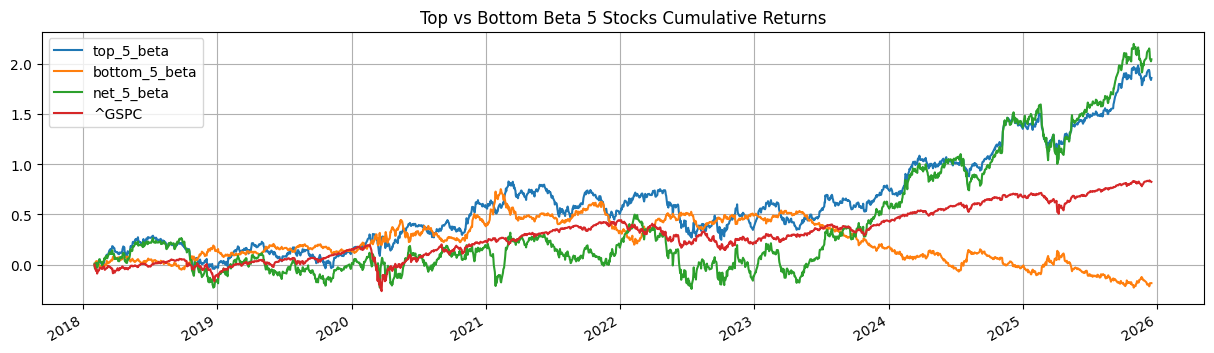

In [20]:
pos_count = 5
top_beta_returns_list = []
bottom_beta_returns_list = []
beta_returns_df = pd.DataFrame()

for t in range(1,len(beta_df.columns)):
    period_start = beta_df.columns[t-1]
    period_end = beta_df.columns[t]

    top_beta = beta_df[period_start].nlargest(n = pos_count).index
    bottom_beta = beta_df[period_start].nsmallest(n = pos_count).index
    top_beta_returns = daily_rel_log_returns.loc[period_start:period_end, top_beta].iloc[1:].mean(axis=1)#.sum()
    bottom_beta_returns = daily_rel_log_returns.loc[period_start:period_end, bottom_beta].iloc[1:].mean(axis=1)#.sum()

    top_beta_returns_list.append(top_beta_returns)
    bottom_beta_returns_list.append(bottom_beta_returns)

top_beta_returns_df = pd.concat(top_beta_returns_list)
bottom_beta_returns_df = pd.concat(bottom_beta_returns_list)

beta_returns_df[f'top_{pos_count}_beta']  = top_beta_returns_df
beta_returns_df[f'bottom_{pos_count}_beta']  = bottom_beta_returns_df
beta_returns_df[f'net_{pos_count}_beta']  = beta_returns_df[f'top_{pos_count}_beta'].sub(beta_returns_df[f'bottom_{pos_count}_beta'])
beta_returns_df[bm_col] = daily_log_returns[bm_col]
beta_returns_df = beta_returns_df.cumsum()
beta_returns_df.plot(figsize=(15,4), grid = True, title=f'Top vs Bottom Beta {pos_count} Stocks Cumulative Returns'  )

### Backtest beta momentum strategy (rising vs. falling betas)

This code tests a strategy based on beta changes rather than absolute beta levels, targeting stocks with rising or falling systematic risk.

Steps:
1. Calculate month-over-month percentage change in beta values for all stocks to identify momentum in risk profiles
2. Each month, select the 5 stocks with the largest beta increases (rising risk) and 5 with the largest beta decreases (falling risk)
3. Calculate mean daily relative log returns for each portfolio during the holding period
4. Concatenate daily returns into continuous time series, compute long-short spread (falling minus rising), and add benchmark
5. Plot cumulative performance to determine if betting against beta momentum (short rising, long falling) generates alpha

<Axes: title={'center': '5 Fallling V. Rising Betas Cumulative Returns'}>

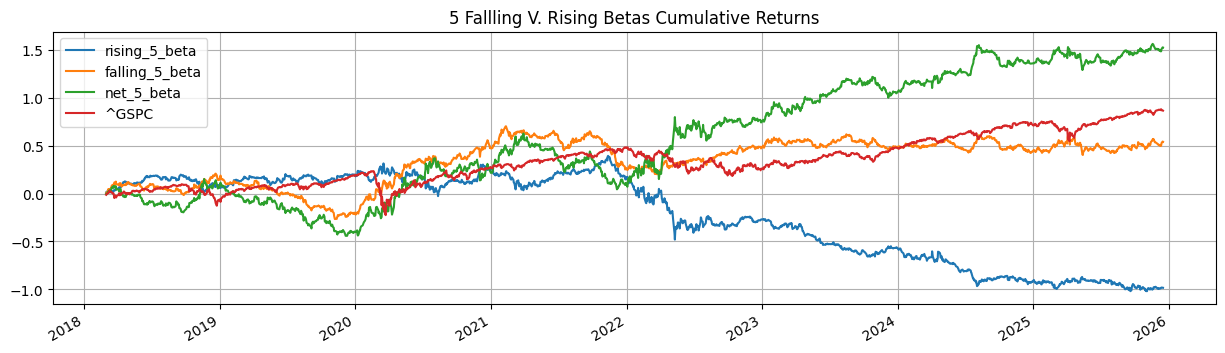

In [21]:
beta_diff = beta_df.pct_change(axis=1, fill_method = None).dropna(axis=1, how = 'all')
top_beta_diff_returns_list = []
bottom_beta_diff_returns_list = []
beta_returns_diff = pd.DataFrame()

for t in range(1,len(beta_diff.columns)):
    period_start = beta_diff.columns[t-1]
    period_end = beta_diff.columns[t]

    top_beta = beta_diff[period_start].nlargest(n = pos_count).index
    bottom_beta = beta_diff[period_start].nsmallest(n = pos_count).index
    top_beta_diff_returns = daily_rel_log_returns.loc[period_start:period_end, top_beta].iloc[1:].mean(axis=1)#.sum()
    bottom_beta_diff_returns = daily_rel_log_returns.loc[period_start:period_end, bottom_beta].iloc[1:].mean(axis=1)#.sum()

    top_beta_diff_returns_list.append(top_beta_diff_returns)
    bottom_beta_diff_returns_list.append(bottom_beta_diff_returns)
top_beta_diff_returns_df = pd.concat(top_beta_diff_returns_list)
bottom_beta_diff_returns_df = pd.concat(bottom_beta_diff_returns_list)

beta_returns_diff[f'rising_{pos_count}_beta']  = top_beta_diff_returns_df
beta_returns_diff[f'falling_{pos_count}_beta']  = bottom_beta_diff_returns_df
beta_returns_diff[f'net_{pos_count}_beta']  = beta_returns_diff[f'falling_{pos_count}_beta'].sub(beta_returns_diff[f'rising_{pos_count}_beta'])
beta_returns_diff[bm_col] = daily_log_returns[bm_col]
beta_returns_diff = beta_returns_diff.cumsum()
beta_returns_diff.plot(figsize=(15,4), grid = True, title=f'{pos_count} Fallling V. Rising Betas Cumulative Returns'  )